## Раздел IV-2. Модель на базе LASSO-регрессии.

#### метод LASSO выбран потому, что в процессе разведочного анализа выявлено наличие парных корреляций в исследуемом наборе данных. LASSO-регрессия является наилучшим линейным методом справляющимся с мультиколлинеарностью. 


In [239]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime

In [240]:
# загрузим очищенный набор 
orders = pd.read_csv('orders_3-1.csv', low_memory=False)

### a) подготовка данных  для работы LASSO агоритма 

In [241]:
# Применим DictVectorizer для получения one-hot-кодирования 
# категориальных признаков CUST_CITY, CUST_NAM, CUST_CAT, CUST_ZIP_C

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()

In [242]:
orders_cat = orders[['CUST_CITY', 'CUST_NAM', 'CUST_CAT', 'CUST_ZIP_C']].to_dict('records')

In [243]:
# преобразуем категориальные переменные в их числовое представление

cat_num = dv.fit_transform(orders_cat)
print cat_num.shape

(114793, 1095)


In [244]:
# удалим из основного набора категориальные признаки
orders.drop(['CUST_CITY', 'CUST_NAM', 'CUST_CAT', 'CUST_ZIP_C'], axis=1, inplace=True)

In [245]:
# выделим из датафрейма целевую переменную и удалим ее из датафрейма
y = orders.SA_HDR_AMT
orders.drop(['SA_HDR_AMT'], axis=1, inplace=True)

In [246]:
# создадим из датафрейма матрицу 
num_features = np.array(orders)

In [247]:
# объединим матрицы преобразованых категориальных и числовых признаков
from scipy.sparse import hstack
orders_num = hstack([num_features, cat_num])

In [248]:
orders_num.shape

(114793, 1109)

In [249]:
#### разделим выборку на обучающий и тестовый наборы (80%, 20%)

X_train = orders_num.A[:int(orders_num.shape[0] * 0.8)]
X_test = orders_num.A[int(orders_num.shape[0] * .8) :]
y_train = y[: int(y.shape[0] * .8)]
y_test = y[int(y.shape[0] * .8) :]

print 'обучающий набор: ', X_train.shape 
print 'тестовый набор:  ', X_test.shape
print 'целевые пересенные: ', y_train.shape, y_test.shape

обучающий набор:  (91834, 1109)
тестовый набор:   (22959, 1109)
целевые пересенные:  (91834,) (22959,)


### б) обучим модель на выборке X_train

In [250]:
from sklearn.linear_model import Lasso

In [256]:
ls_model = Lasso(normalize=False, random_state=41, alpha=1.0, max_iter=1e3)

In [257]:
ls_model.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000.0,
   normalize=False, positive=False, precompute=False, random_state=41,
   selection='cyclic', tol=0.0001, warm_start=False)

### в) построим прогноз и оценим качество модели по критерию r2

In [258]:
y_pred = ls_model.predict(X_test)   # построим прогнозные значения на тесте
y_true = np.array(y_test)       # истинные значения на тесте

In [259]:
from sklearn.metrics import r2_score
print 'коэф.детерминации r2 = {}'.format(r2_score(y_true, y_pred))

коэф.детерминации r2 = 0.460813417938


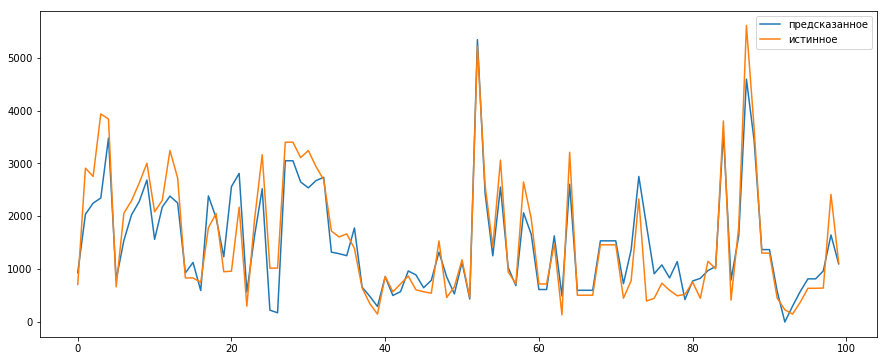

In [260]:
plt.figure(figsize=(15,6))
plt.plot(y_pred[1000:1100], label=u'предсказанное' )
plt.plot(y_true[1000:1100], label=u'истинное')
plt.legend();

## Вывод.
Регрессионная модель показала плохое качество прогноза на тестовой выборке (__0.461__) даже с учетом L2-регуляризации.
Это объясняется наличием значительной корреляции между некоторыми признаками и незначительной корреляцией с целевой переменной (__см.ниже__).
Кроме того, регрессия имеет большие значения коэффициентов, что свидетельствует о переобученности модели.

_Таким образом данная модель проигрывает по качеству решающим деревьям_

In [183]:
# коэффициенты корреляции признаков с целевой переменной
orders.corrwith(y)

CUST_PROFI        0.097388
CUST_PRO01        0.093763
CUST_PRO02        0.092680
CUST_PRO03       -0.026073
CUST_PRO04       -0.029173
CUST_PRO05       -0.021257
LINES_QTY         0.262483
ITEMS_QTY         0.876468
CUST_RET_QTY     -0.151902
CUST_RET_SUM      0.143007
CUST_TIME_DEAL   -0.034819
CUST_TOTAL_AMT    0.000602
SA_HDR_DOW        0.030608
CUST_DIST        -0.027995
dtype: float64

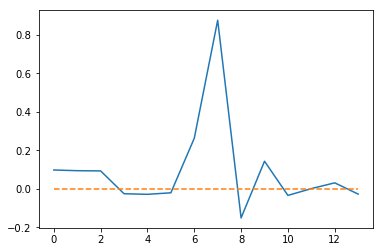

In [301]:
plt.plot(orders.corrwith(y).values)
plt.plot(np.zeros(14), '--');

In [289]:
# посчитанные коэффициенты регрессии
ls_model.coef_[ls_model.coef_ > 0]

array([  1.19764672e+02,   2.83348456e+01,   3.40538983e+01,
         6.00848789e-04,   2.05971869e-02,   1.52707493e+03,
         1.04978469e+01,   2.59477940e+02,   1.05173519e+01,
         2.62771351e+02,   7.07558714e+01,   1.83673040e+01,
         4.55262353e+02,   5.71271527e+00,   2.48721441e+01,
         1.68454280e+02,   9.59414981e+01,   6.63351025e+01,
         4.44162336e+02,   2.41890663e+02,   1.55341858e+02,
         5.31541938e+01,   2.16605219e+02,   3.32678804e+02,
         3.02494617e+04,   8.13047959e+00,   4.11133298e+02,
         1.21873050e+04,   2.99618114e+02,   2.74291886e+02,
         2.44277852e+02,   1.53005133e+03,   9.05385245e+00,
         8.50429183e+02,   5.51131484e+03,   1.59698967e+01,
         4.60912896e-03])

In [303]:
coef = ls_model.coef_[ls_model.coef_ > 0]

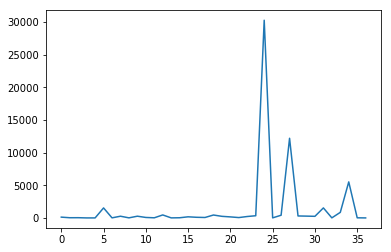

In [304]:
plt.plot(coef);